In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler
from keras.layers import concatenate
from scipy import misc
import scipy.ndimage as ndimage

Using TensorFlow backend.


In [2]:
base_path = '/volumes/data/wht_bld_cell_count/data/'

def read_data(base_path):
    data = []
    anno = []
    imList = os.listdir(base_path)
    for i in range(len(imList)): 
        if 'cell' in imList[i]:
            img1 = misc.imread(os.path.join(base_path,imList[i]))
            data.append(img1)
            
            img2_ = misc.imread(os.path.join(base_path, imList[i][:3] + 'dots.png'))
            img2 = 100.0 * (img2_[:,:,0] > 0)
            img2 = ndimage.gaussian_filter(img2, sigma=(1, 1), order=0)
            anno.append(img2)
    return np.asarray(data, dtype = 'float32'), np.asarray(anno, dtype = 'float32')

### Defining model

In [3]:
import numpy as np
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import (
    Input,
    Activation,
    Merge,
    merge,
    Dropout,
    Reshape,
    Permute,
    Dense,
    UpSampling2D,
    Flatten
    )
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import (
    Convolution2D)
from keras.layers.pooling import (
    MaxPooling2D,
    AveragePooling2D
    )
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

K.set_image_data_format('channels_last') 

In [4]:
def step_decay(epoch):
    step = 16
    num =  epoch // step 
    if num % 3 == 0:
        lrate = 1e-3
    elif num % 3 == 1:
        lrate = 1e-4
    else:
        lrate = 1e-5
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return np.float(lrate)

smooth = 1.

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# def dice_coef_loss(y_true, y_pred):
#     return 1. / (dice_coef(y_true, y_pred) + smooth)

# def custom_mean_absolute_error(y_true, y_pred):
#     return K.mean(K.abs(K.sum(y_pred)-K.sum(y_true))) / (100.0)

In [5]:
weight_decay = 1e-5

def _conv_bn_relu(filters, row, col, strides = 1):
    def f(input):
        conv_a = Convolution2D(filters, kernel_size = (row, col), strides  = strides,
                               kernel_initializer = 'orthogonal', 
                               padding='same', use_bias= False)(input)
        norm_a = BatchNormalization()(conv_a)
        act_a = Activation(activation = 'relu')(norm_a)
        return act_a
    return f
    
def _conv_bn_relu_x2(filters, row, col, strides = 1):
    def f(input):
        conv_a = Convolution2D(filters, kernel_size = (row, col), strides  = strides,
                               kernel_initializer = 'orthogonal', padding = 'same',use_bias = False,
                               kernel_regularizer = l2(weight_decay),
                               bias_regularizer = l2(weight_decay))(input)
        norm_a = BatchNormalization()(conv_a)
        act_a = Activation(activation = 'relu')(norm_a)
        conv_b = Convolution2D(filters, kernel_size = (row, col), strides  = strides,
                               kernel_initializer = 'orthogonal', padding = 'same',use_bias = False,
                               kernel_regularizer = l2(weight_decay),
                               bias_regularizer = l2(weight_decay))(act_a)
        norm_b = BatchNormalization()(conv_b)
        act_b = Activation(activation = 'relu')(norm_b)
        return act_b
    return f

def U_net_base(input, nb_filter = 64):
    block1 = _conv_bn_relu_x2(nb_filter,3,3)(input)
    pool1 = MaxPooling2D(pool_size=(2,2))(block1)
    # =========================================================================
    block2 = _conv_bn_relu_x2(nb_filter,3,3)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(block2)
    # =========================================================================
    block3 = _conv_bn_relu_x2(nb_filter,3,3)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(block3)
    # =========================================================================
    block4 = _conv_bn_relu_x2(nb_filter,3,3)(pool3)
    up4 = concatenate([UpSampling2D(size=(2, 2))(block4), block3] ,  axis=-1)
    # =========================================================================
    block5 = _conv_bn_relu_x2(nb_filter,3,3)(up4)
    up5 = concatenate([UpSampling2D(size=(2, 2))(block5), block2] ,  axis=-1)
    # =========================================================================
    block6 = _conv_bn_relu_x2(nb_filter,3,3)(up5)
    up6 = concatenate([UpSampling2D(size=(2, 2))(block6), block1] ,  axis=-1)
    # =========================================================================
    block7 = _conv_bn_relu(nb_filter,3,3)(up6)
    return block7

def buildModel_U_net (input_dim):
    input_ = Input (shape = (input_dim))
    # =========================================================================
    act_ = U_net_base (input_, nb_filter = 64 )
    # =========================================================================
    density_pred =  Convolution2D(1, kernel_size = (1, 1), use_bias= False, activation='linear',
                                   kernel_initializer = 'orthogonal',name='pred',padding = 'same')(act_)
    # =========================================================================
#     # =========================================================================
#     density_pred =  Convolution2D(1, kernel_size = (1, 1), activation='sigmoid',
#                                   name='pred')(act_)
#     # =========================================================================
    model = Model (inputs = input_, outputs = density_pred)
    opt = RMSprop(1e-3)
#     model.compile(optimizer = opt, loss=dice_coef_loss, metrics=[dice_coef])
#     model.compile(optimizer=Adam(lr = 1e-5), loss = 'mse')
    model.compile(optimizer=opt, loss = 'mse')
    return model

In [6]:
data, anno = read_data(base_path)
anno = np.expand_dims(anno, axis = -1)

mean = np.mean(data)
std = np.std(data)

print('-'*30)
print('Mean and std for future use, Mean: {}, std: {}'.format(mean,std))
print('-'*30) 
data_ = (data - mean) / std

train_data = data_[:150]
train_anno = anno[:150]

val_data = data_[150:]
val_anno = anno[150:]

print('-'*30)
print('Creating and compiling the fully convolutional Unet networks.')
print('-'*30)    

model = buildModel_U_net(input_dim = (256,256,3))
model_checkpoint = ModelCheckpoint('cell_counting.hdf5', monitor='loss', save_best_only=True)
change_lr = LearningRateScheduler(step_decay)

------------------------------
Mean and std for future use, Mean: 30.462919235229492, std: 52.186981201171875
------------------------------
------------------------------
Creating and compiling the fully convolutional Unet networks.
------------------------------


In [7]:
print('...Fitting model...')
print('-'*30)

datagen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
    zoom_range = 0.3,
    shear_range = 0.,
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True, # randomly flip images
    fill_mode = 'constant',
    data_format = K.image_data_format()) 

simple_datagen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.,  # randomly shift images vertically (fraction of total height)
    zoom_range = 0.,
    shear_range = 0.,
    horizontal_flip = False,  # randomly flip images
    vertical_flip = False, # randomly flip images
    fill_mode = 'constant',
    data_format = K.image_data_format()) 

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
                    generator = datagen.flow(train_data,
                                 train_anno,
                                 batch_size = 16
                                 ),
                    validation_data = simple_datagen.flow(val_data,
                                        val_anno,
                                        batch_size = 50),
                    steps_per_epoch = train_data.shape[0]//16,
                    
                    validation_steps = 1,
                    epochs = 48,
                    callbacks = [model_checkpoint, change_lr],
#                     callbacks = [model_checkpoint],
                    verbose = 1
                   )

model.load_weights('cell_counting.hdf5')
model.save('unet_model_counting.h5')

...Fitting model...
------------------------------
Learning rate for epoch 1 is 0.001.
Epoch 1/48
9/9 [==============================] - 23s - loss: 3.1864 - val_loss: 2.1758
Learning rate for epoch 2 is 0.001.
Epoch 2/48
9/9 [==============================] - 13s - loss: 2.2100 - val_loss: 2.4046
Learning rate for epoch 3 is 0.001.
Epoch 3/48
9/9 [==============================] - 11s - loss: 2.2211 - val_loss: 11.9935
Learning rate for epoch 4 is 0.001.
Epoch 4/48
9/9 [==============================] - 12s - loss: 2.1916 - val_loss: 2.0698
Learning rate for epoch 5 is 0.001.
Epoch 5/48
9/9 [==============================] - 11s - loss: 2.2693 - val_loss: 2.6789
Learning rate for epoch 6 is 0.001.
Epoch 6/48
9/9 [==============================] - 12s - loss: 2.1551 - val_loss: 2.3047
Learning rate for epoch 7 is 0.001.
Epoch 7/48
9/9 [==============================] - 11s - loss: 2.2648 - val_loss: 3.1079
Learning rate for epoch 8 is 0.001.
Epoch 8/48
9/9 [============================

In [8]:
A = model.predict(val_data)
mean_diff = np.average(np.abs(np.sum(np.sum(A,1),1)-np.sum(np.sum(val_anno,1),1))) / (100.0)
print('After training, the difference is : {} cells per image.'.format(np.abs(mean_diff)))

After training, the difference is : 140.316650390625 cells per image.


In [9]:
def plot_history(history):
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title('model loss'), plt.ylabel('loss'), plt.xlabel('epoch'), plt.ylim((1.8,3.2))
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    print('Last epoch Train loss:', history.history['loss'][-1])
    print('last epoch Test loss:', history.history['val_loss'][-1])
    
# def plot_history(history):
#     plt.rcParams["figure.figsize"] = [15,5]
#     # summarize history for loss
#     plt.subplot(1,2,1)
#     plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
#     plt.title('model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
#     # summarize history for accuracy
#     plt.subplot(1,2,2)
#     plt.plot(history.history['dice_coef']), plt.plot(history.history['val_dice_coef'])
#     plt.title(' model Dice Coefficient'), plt.ylabel('Dice Coef'), plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
#     plt.show()
#     print('Train Dice Coef:', history.history['dice_coef'][-1])
#     print('Test Dice Coef:', history.history['val_dice_coef'][-1])

Last epoch Train loss: 2.16542052511
last epoch Test loss: 2.12847685814


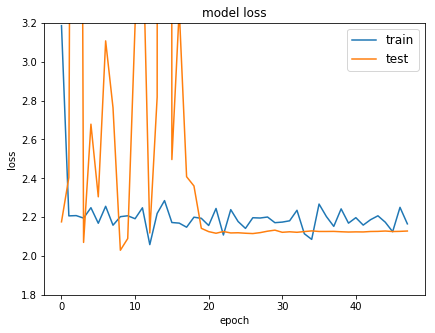

In [10]:
plot_history(history)